In [42]:
# Relevant imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif

In [43]:
# Import train + test datasets and split data
train_data = pd.read_csv('/mnt/c/Users/kpali/Documents/ML/Titanic-Kaggle/train.csv')
test_data = pd.read_csv('/mnt/c/Users/kpali/Documents/ML/Titanic-Kaggle/test.csv')
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)


In [44]:
# Check number of rows
X_train.shape

(712, 11)

In [45]:
# Counts of nulls per column
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            144
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          547
Embarked         2
dtype: int64

In [46]:
# Drop Cabin column as it doesn't contain enough useful information
X_train = X_train.drop('Cabin', axis=1)

In [47]:
# Checkout missing Embarked values and see if there are passengers with similar name for imputation
print(X_train[X_train['Embarked'].isnull()])
print(X_train[X_train['Name'].str.contains(r'Stone', regex=True)])
print(X_train[X_train['Name'].str.contains(r'Icard', regex=True)])

     PassengerId  Pclass                                       Name     Sex  \
61            62       1                        Icard, Miss. Amelie  female   
829          830       1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      Age  SibSp  Parch  Ticket  Fare Embarked  
61   38.0      0      0  113572  80.0      NaN  
829  62.0      0      0  113572  80.0      NaN  
     PassengerId  Pclass                                               Name  \
829          830       1          Stone, Mrs. George Nelson (Martha Evelyn)   
319          320       1  Spedden, Mrs. Frederic Oakley (Margaretta Corn...   

        Sex   Age  SibSp  Parch  Ticket   Fare Embarked  
829  female  62.0      0      0  113572   80.0      NaN  
319  female  40.0      1      1   16966  134.5        C  
    PassengerId  Pclass                 Name     Sex   Age  SibSp  Parch  \
61           62       1  Icard, Miss. Amelie  female  38.0      0      0   

    Ticket  Fare Embarked  
61  113572  80.0      

In [48]:
# Drop null values for X_train and y_train 
null_embarked_indexes = X_train[X_train['Embarked'].isnull()].index.tolist()
X_train = X_train.drop(null_embarked_indexes)
y_train = y_train.drop(null_embarked_indexes)


count    710.000000
mean      30.096148
std       13.228302
min        0.420000
25%       22.000000
50%       30.096148
75%       36.000000
max       80.000000
Name: Age, dtype: float64


<Axes: title={'center': 'Histogram of Age'}, xlabel='Age', ylabel='Frequency'>

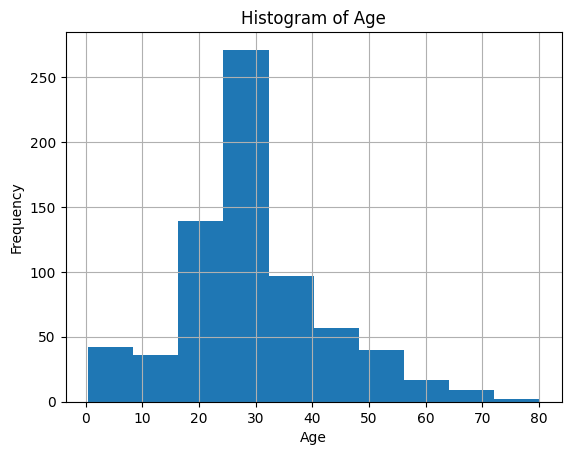

In [61]:
# Age Distribution
print(X_train['Age'].describe())
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
X_train['Age'].hist()

In [50]:
# Impute age
mean_imputation = SimpleImputer(strategy='mean')
age_imputed = mean_imputation.fit_transform(X_train[['Age']])
X_train['Age'] = age_imputed

In [51]:
X_train.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [52]:
# Compute mutual information score
def calc_mi_scores(X:pd.DataFrame,y:pd.Series):
    le = LabelEncoder()
    X_mi = X.copy()
    for col in X_mi.select_dtypes("object").columns:
        X_mi[col] = le.fit_transform(X_mi[col])
    mi_scores = mutual_info_classif(X_mi,y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

calc_mi_scores(X_train, y_train)

Sex            0.136966
Fare           0.127450
Ticket         0.099317
Pclass         0.035620
SibSp          0.012663
Parch          0.007842
Age            0.001573
PassengerId    0.000000
Name           0.000000
Embarked       0.000000
Name: MI Scores, dtype: float64

In [53]:
# Dropping unimportant features
X_train = X_train.drop(['Name', 'PassengerId', 'Embarked'], axis=1)

In [64]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare
301,3,male,30.096148,2,0,367226,23.2500
309,1,female,30.000000,0,0,PC 17485,56.9292
516,2,female,34.000000,0,0,C.A. 34260,10.5000
120,2,male,21.000000,2,0,S.O.C. 14879,73.5000
570,2,male,62.000000,0,0,S.W./PP 752,10.5000


In [65]:
# Merge predictors and target into single dataframe
merged_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
merged_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Survived
301,3,male,30.096148,2,0,367226,23.2500,1
309,1,female,30.000000,0,0,PC 17485,56.9292,1
516,2,female,34.000000,0,0,C.A. 34260,10.5000,1
120,2,male,21.000000,2,0,S.O.C. 14879,73.5000,0
570,2,male,62.000000,0,0,S.W./PP 752,10.5000,1


In [67]:
# Generate frequency plot
def generate_frequency_plot(column_name:str):
    frequency = X_train[column_name].value_counts()
    plt.title(f'Frequency by {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Frequency')
    frequency.plot(kind='bar')

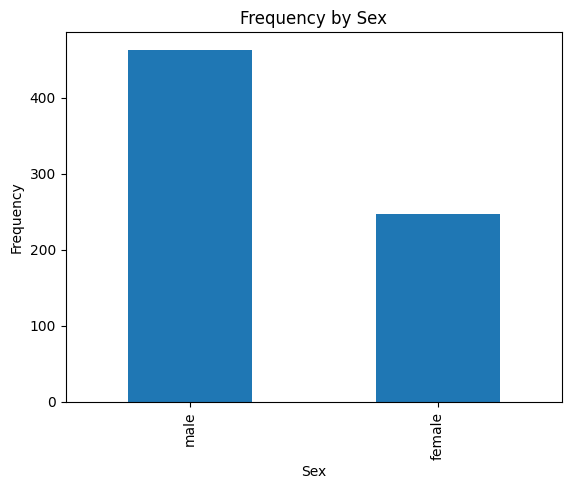

In [68]:
# Exploring Sex
generate_frequency_plot('Sex')

In [66]:
# Calculate survival rates by gender
survival_rate_male = 100.00 * (merged_train[merged_train['Sex'].isin(['male']) & merged_train['Survived'] == 1].shape[0] / merged_train[merged_train['Sex'].isin(['male'])].shape[0])
survival_rate_female = 100.00 * (merged_train[merged_train['Sex'].isin(['female']) & merged_train['Survived'] == 1].shape[0] / merged_train[merged_train['Sex'].isin(['female'])].shape[0])
print('Male survival rate: ', survival_rate_male)
print('Female survival rate', survival_rate_female)

Male survival rate:  18.3585313174946
Female survival rate 73.68421052631578


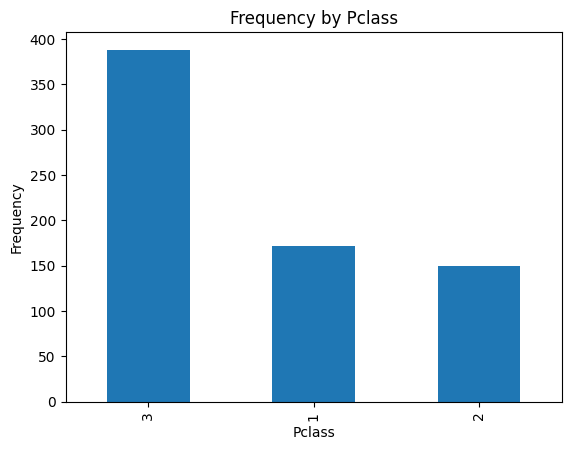

In [69]:
# Exploring Pclass
generate_frequency_plot('Pclass')

In [71]:
# Survival rate by within Pclass + aggregate
survival_rate_by_pclass = merged_train.groupby(['Pclass'])['Survived'].agg(['sum','count']).reset_index()
survival_rate_by_pclass['Survived_Percentage'] = 100.00 * (survival_rate_by_pclass['sum'] / survival_rate_by_pclass['count'])
survival_rate_by_pclass.head()

,Pclass,sum,count,Survived_Percentage
0,1,107,172,62.209302
1,2,73,150,48.666667
2,3,87,388,22.422680
